
# TP Final — Predicción de Precios de Viviendas

**Fecha:** 2025-11-04  
**Equipo:** Apaza, Cristina - Benitez, Santiago - San Martin, Leonel - Plodari, Gianluca   
**Objetivo de negocio:** Estimar el precio de venta de una vivienda para **tasar correctamente**, **acelerar la venta** y **mejorar la rentabilidad** de inmobiliarias y bancos.

**Flujo de trabajo:**

![imagen](flujo_trabajo.png)

**Link al repo de GitHub**: https://github.com/gianplod/Aprendizaje_Automatico

**Link a app de Streamlit**: https://smart-price.streamlit.app/

**NOTAS**: recomendamos correr la notebook con Python 3.10, siguiendo los requirements.txt - no obstante la mayoría de las funcionalidades deberían correr en Python 3.11.

## CAMPOS DEL DATASET

| **Atributo**   | **Descripción (en español)**                                       | **Opciones posibles**                                                                                                                                                                                                                                                                                                                                                                                                      |
| -------------- | ------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `MSSubClass`   | Identifica el tipo de vivienda involucrada en la venta.            | 20: 1-STORY 1946 & NEWER ALL STYLES; 30: 1-STORY 1945 & OLDER; 40: 1-STORY W/FINISHED ATTIC ALL AGES; 45: 1-1/2 STORY UNFINISHED ALL AGES; 50: 1-1/2 STORY FINISHED ALL AGES; 60: 2-STORY 1946 & NEWER; 70: 2-STORY 1945 & OLDER; 75: 2-1/2 STORY ALL AGES; 80: SPLIT OR MULTI-LEVEL; 85: SPLIT FOYER; 90: DUPLEX; 120: 1-STORY PUD; 150: 1-1/2 STORY PUD; 160: 2-STORY PUD; 180: PUD MULTILEVEL; 190: 2 FAMILY CONVERSION |
| `MSZoning`     | Clasificación general de zonificación del terreno.                 | A, C, FV, I, RH, RL, RP, RM                                                                                                                                                                                                                                                                                                                                                                                                |
| `LotFrontage`  | Pies lineales de calle conectados a la propiedad.                  | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `LotArea`      | Tamaño del terreno en pies cuadrados.                              | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `Street`       | Tipo de acceso vial.                                               | Grvl, Pave                                                                                                                                                                                                                                                                                                                                                                                                                 |
| `Alley`        | Tipo de acceso por callejón.                                       | Grvl, Pave, NA                                                                                                                                                                                                                                                                                                                                                                                                             |
| `LotShape`     | Forma del terreno.                                                 | Reg, IR1, IR2, IR3                                                                                                                                                                                                                                                                                                                                                                                                         |
| `LandContour`  | Relieve o nivel del terreno.                                       | Lvl, Bnk, HLS, Low                                                                                                                                                                                                                                                                                                                                                                                                         |
| `Utilities`    | Tipo de servicios disponibles.                                     | AllPub, NoSewr, NoSeWa, ELO                                                                                                                                                                                                                                                                                                                                                                                                |
| `LotConfig`    | Configuración del terreno.                                         | Inside, Corner, CulDSac, FR2, FR3                                                                                                                                                                                                                                                                                                                                                                                          |
| `LandSlope`    | Pendiente del terreno.                                             | Gtl, Mod, Sev                                                                                                                                                                                                                                                                                                                                                                                                              |
| `Neighborhood` | Vecindario dentro de los límites de Ames.                          | Blmngtn, Blueste, BrDale, BrkSide, ClearCr, CollgCr, Crawfor, Edwards, Gilbert, IDOTRR, MeadowV, Mitchel, Names, NoRidge, NPkVill, NridgHt, NWAmes, OldTown, SWISU, Sawyer, SawyerW, Somerst, StoneBr, Timber, Veenker                                                                                                                                                                                                     |
| `Condition1`   | Proximidad a diversas condiciones.                                 | Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe                                                                                                                                                                                                                                                                                                                                                                    |
| `Condition2`   | Segunda condición de proximidad (si aplica).                       | Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe                                                                                                                                                                                                                                                                                                                                                                    |
| `BldgType`     | Tipo de vivienda.                                                  | 1Fam, 2FmCon, Duplx, TwnhsE, TwnhsI                                                                                                                                                                                                                                                                                                                                                                                        |
| `HouseStyle`   | Estilo o cantidad de pisos.                                        | 1Story, 1.5Fin, 1.5Unf, 2Story, 2.5Fin, 2.5Unf, SFoyer, SLvl                                                                                                                                                                                                                                                                                                                                                               |
| `OverallQual`  | Calidad general de materiales y terminaciones.                     | 1 a 10 (Very Poor → Very Excellent)                                                                                                                                                                                                                                                                                                                                                                                        |
| `OverallCond`  | Condición general de la vivienda.                                  | 1 a 10 (Very Poor → Very Excellent)                                                                                                                                                                                                                                                                                                                                                                                        |
| `YearBuilt`    | Año de construcción original.                                      | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `YearRemodAdd` | Año de remodelación (igual al de construcción si no hubo cambios). | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `RoofStyle`    | Tipo de techo.                                                     | Flat, Gable, Gambrel, Hip, Mansard, Shed                                                                                                                                                                                                                                                                                                                                                                                   |
| `RoofMatl`     | Material del techo.                                                | ClyTile, CompShg, Membran, Metal, Roll, Tar&Grv, WdShake, WdShngl                                                                                                                                                                                                                                                                                                                                                          |
| `Exterior1st`  | Revestimiento exterior principal.                                  | AsbShng, AsphShn, BrkComm, BrkFace, CBlock, CemntBd, HdBoard, ImStucc, MetalSd, Other, Plywood, PreCast, Stone, Stucco, VinylSd, Wd Sdng, WdShing                                                                                                                                                                                                                                                                          |
| `Exterior2nd`  | Revestimiento exterior secundario.                                 | Igual a `Exterior1st`                                                                                                                                                                                                                                                                                                                                                                                                      |
| `MasVnrType`   | Tipo de revestimiento de mampostería.                              | BrkCmn, BrkFace, CBlock, None, Stone                                                                                                                                                                                                                                                                                                                                                                                       |
| `MasVnrArea`   | Área de mampostería (pies²).                                       | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `ExterQual`    | Calidad del material exterior.                   | Ex, Gd, TA, Fa, Po                         |
| `ExterCond`    | Estado del material exterior.                    | Ex, Gd, TA, Fa, Po                         |
| `Foundation`   | Tipo de fundación.                               | BrkTil, CBlock, PConc, Slab, Stone, Wood   |
| `BsmtQual`     | Altura del sótano.                               | Ex, Gd, TA, Fa, Po, NA                     |
| `BsmtCond`     | Condición general del sótano.                    | Ex, Gd, TA, Fa, Po, NA                     |
| `BsmtExposure` | Paredes con salida al exterior.                  | Gd, Av, Mn, No, NA                         |
| `BsmtFinType1` | Tipo 1 de área terminada en el sótano.           | GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA           |
| `BsmtFinSF1`   | Superficie terminada (tipo 1).                   | —                                          |
| `BsmtFinType2` | Tipo 2 de área terminada en el sótano.           | GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA           |
| `BsmtFinSF2`   | Superficie terminada (tipo 2).                   | —                                          |
| `BsmtUnfSF`    | Superficie sin terminar en sótano.               | —                                          |
| `TotalBsmtSF`  | Superficie total del sótano.                     | —                                          |
| `Heating`      | Tipo de calefacción.                             | Floor, GasA, GasW, Grav, OthW, Wall        |
| `HeatingQC`    | Calidad del sistema de calefacción.              | Ex, Gd, TA, Fa, Po                         |
| `CentralAir`   | Aire acondicionado central.                      | N, Y                                       |
| `Electrical`   | Sistema eléctrico.                               | SBrkr, FuseA, FuseF, FuseP, Mix            |
| `1stFlrSF`     | Superficie del primer piso (pies²).              | —                                          |
| `2ndFlrSF`     | Superficie del segundo piso (pies²).             | —                                          |
| `LowQualFinSF` | Superficie terminada de baja calidad.            | —                                          |
| `GrLivArea`    | Superficie habitable sobre el nivel del suelo.   | —                                          |
| `BsmtFullBath` | Baños completos en sótano.                       | —                                          |
| `BsmtHalfBath` | Medios baños en sótano.                          | —                                          |
| `FullBath`     | Baños completos sobre el suelo.                  | —                                          |
| `HalfBath`     | Medios baños sobre el suelo.                     | —                                          |
| `Bedroom`      | Dormitorios sobre el suelo (sin sótano).         | —                                          |
| `Kitchen`      | Cocinas sobre el suelo.                          | —                                          |
| `KitchenQual`  | Calidad de la cocina.                            | Ex, Gd, TA, Fa, Po                         |
| `TotRmsAbvGrd` | Habitaciones totales sobre el suelo (sin baños). | —                                          |
| `Functional`   | Funcionalidad de la vivienda.                    | Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal |
| `Fireplaces`   | Número de chimeneas.                             | —                                          |
| `FireplaceQu`  | Calidad de la chimenea.                          | Ex, Gd, TA, Fa, Po, NA                     |
| `GarageType`    | Ubicación/tipo de garaje.                                     | 2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA |
| `GarageYrBlt`   | Año de construcción del garaje.                               | —                                                     |
| `GarageFinish`  | Terminación interior del garaje.                              | Fin, RFn, Unf, NA                                     |
| `GarageCars`    | Capacidad (n.º autos).                                        | —                                                     |
| `GarageArea`    | Superficie del garaje (pies²).                                | —                                                     |
| `GarageQual`    | Calidad del garaje.                                           | Ex, Gd, TA, Fa, Po, NA                                |
| `GarageCond`    | Condición del garaje.                                         | Ex, Gd, TA, Fa, Po, NA                                |
| `PavedDrive`    | Entrada pavimentada.                                          | Y, P, N                                               |
| `WoodDeckSF`    | Superficie de deck de madera (pies²).                         | —                                                     |
| `OpenPorchSF`   | Superficie de porche abierto (pies²).                         | —                                                     |
| `EnclosedPorch` | Superficie de porche cerrado (pies²).                         | —                                                     |
| `3SsnPorch`     | Porche de tres estaciones (pies²).                            | —                                                     |
| `ScreenPorch`   | Porche con malla (pies²).                                     | —                                                     |
| `PoolArea`      | Superficie de piscina (pies²).                                | —                                                     |
| `PoolQC`        | Calidad de la piscina.                                        | Ex, Gd, TA, Fa, NA                                    |
| `Fence`         | Calidad de la cerca.                                          | GdPrv, MnPrv, GdWo, MnWw, NA                          |
| `MiscFeature`   | Características adicionales no incluidas en otras categorías. | Elev, Gar2, Othr, Shed, TenC, NA                      |
| `MiscVal`       | Valor monetario de la característica adicional.               | —                                                     |
| `MoSold`        | Mes de venta (MM).                                            | —                                                     |
| `YrSold`        | Año de venta (YYYY).                                          | —                                                     |
| `SaleType`      | Tipo de venta.                                                | WD, CWD, VWD, New, COD, Con, ConLw, ConLI, ConLD, Oth |
| `SaleCondition` | Condición de la venta.                                        | Normal, Abnorml, AdjLand, Alloca, Family, Partial     |


## 1) Configuración e imports

In [2]:
# ============================================
# BLOQUE 1 - Configuración y librerías
# ============================================
import os, zipfile, warnings, json
from pathlib import Path
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

print("✅ Entorno OK. CWD:", os.getcwd())


✅ Entorno OK. CWD: C:\Users\Gianluca\Projects\Aprendizaj_Automatico_final


## 2) Carga de Kaggle

In [4]:
# ============================================
# BLOQUE 2 - Descarga de datos desde Kaggle
# NOTA: en caso de que el import de Kaggle falle, seguir las instruccions sobre el kaggle.json o re ejecutar la celda con los csv correspondientes
# en el directorio data/kaggle
# ============================================

from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = Path("data/kaggle")
DATA_DIR.mkdir(parents=True, exist_ok=True)
train_path = DATA_DIR / "train.csv"
test_path  = DATA_DIR / "test.csv"

def download_from_kaggle():
    api = KaggleApi(); api.authenticate()
    comp = "house-prices-advanced-regression-techniques"
    api.competition_download_files(comp, path=DATA_DIR)
    zf = DATA_DIR / f"{comp}.zip"
    with zipfile.ZipFile(zf, "r") as z:
        z.extractall(DATA_DIR)

if not (train_path.exists() and test_path.exists()):
    try:
        download_from_kaggle()
    except Exception as e:
        raise RuntimeError(f"No pude descargar desde Kaggle: {e}. Copiá los CSV a {DATA_DIR}")

df_train_raw = pd.read_csv(train_path)
df_test_raw  = pd.read_csv(test_path)
print("📄 Shapes -> train:", df_train_raw.shape, "test:", df_test_raw.shape)
display(df_train_raw.head(3))



📄 Shapes -> train: (1460, 81) test: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## 3) AUTO EDA

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 28.44it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ ydata_profiling → house_prices_profile.html


                                             |                                                          | [  0…

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
✅ Sweetviz → sweetviz_report.html
Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)
Shape of your Data Set loaded: (1460, 81)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  3
    Number of Integer-Categorical Columns =  31
    Number of String-Categorical Columns =  37
    Number of Factor-Categoric

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
LotFrontage,float64,17.739726,NA,21.000000,313.000000,"259 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 88 outliers greater than upper bound (111.50) or lower than lower bound(27.50). Cap them or remove them."
MasVnrArea,float64,0.547945,NA,0.000000,1600.000000,"8 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 96 outliers greater than upper bound (415.00) or lower than lower bound(-249.00). Cap them or remove them."
GarageYrBlt,float64,5.547945,NA,1900.000000,2010.000000,"81 missing values. Impute them with mean, median, mode, or a constant value such as 123."
MSSubClass,int64,0.000000,1,20.000000,190.000000,Column has 103 outliers greater than upper bound (145.00) or lower than lower bound(-55.00). Cap them or remove them.
MSZoning,object,0.000000,0,,,1 rare categories: ['C (all)']. Group them into a single category or drop the categories.
LotArea,int64,0.000000,73,1300.000000,215245.000000,Column has 69 outliers greater than upper bound (17673.50) or lower than lower bound(1481.50). Cap them or remove them.
Street,object,0.000000,0,,,No issue
LotShape,object,0.000000,0,,,1 rare categories: ['IR3']. Group them into a single category or drop the categories.
LandContour,object,0.000000,0,,,No issue
Utilities,object,0.000000,0,,,No issue


Number of All Scatter Plots = 6
Could not draw some Time Series plots. agg function failed [how->mean,dtype->object]
All Plots done
Time to run AutoViz = 15 seconds 

 ###################### AUTO VISUALIZATION Completed ########################
✅ AutoViz ejecutado (gráficos inline)


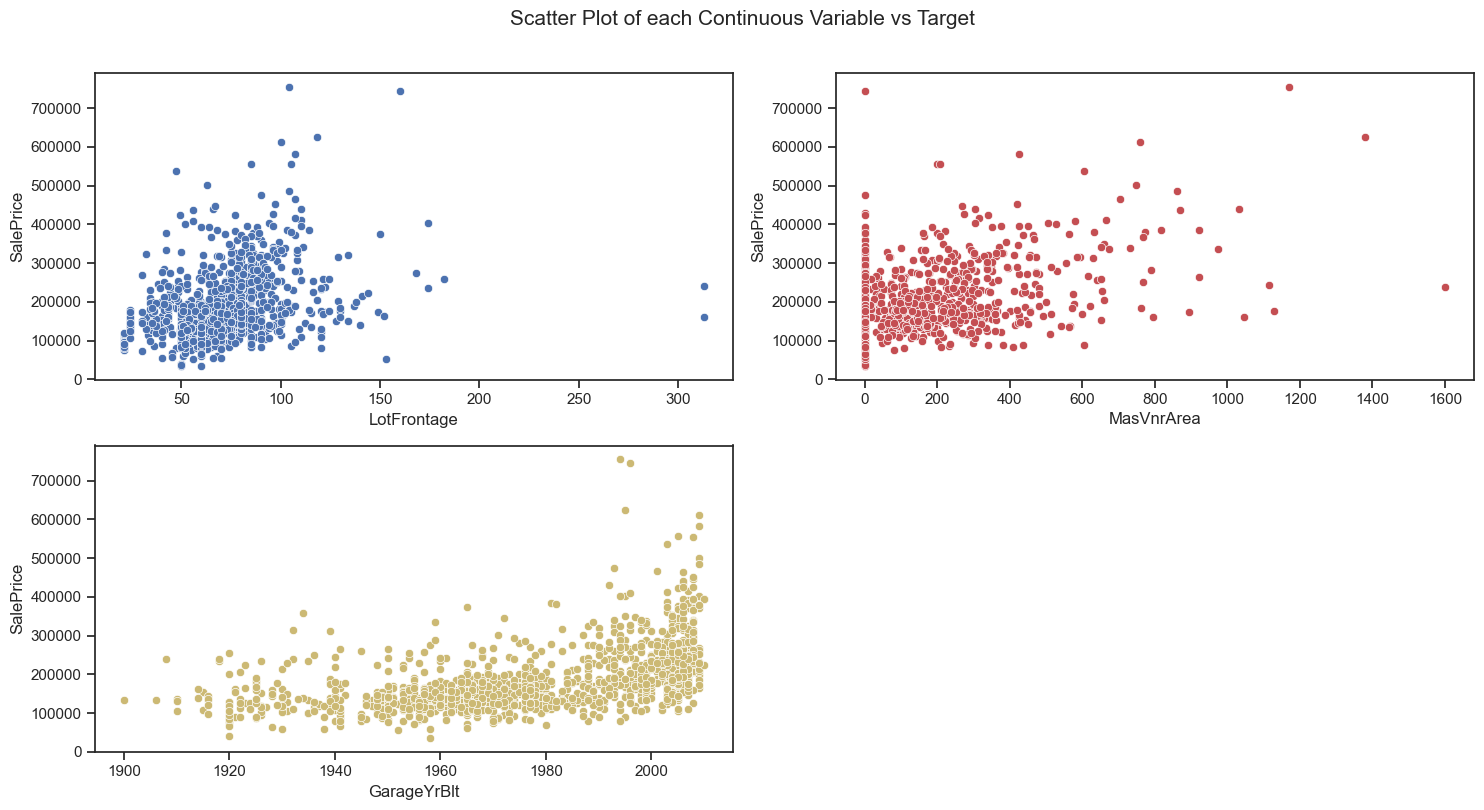

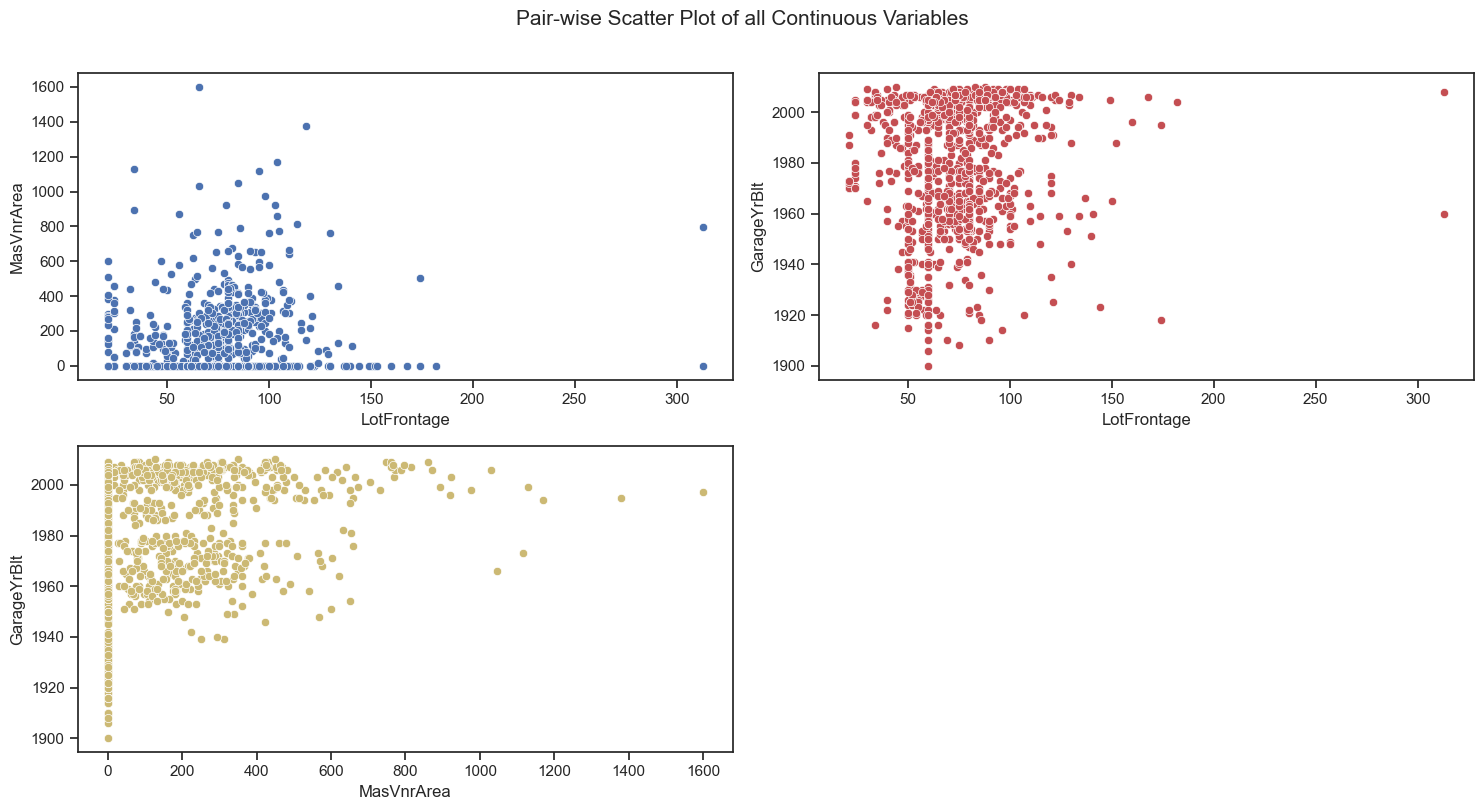

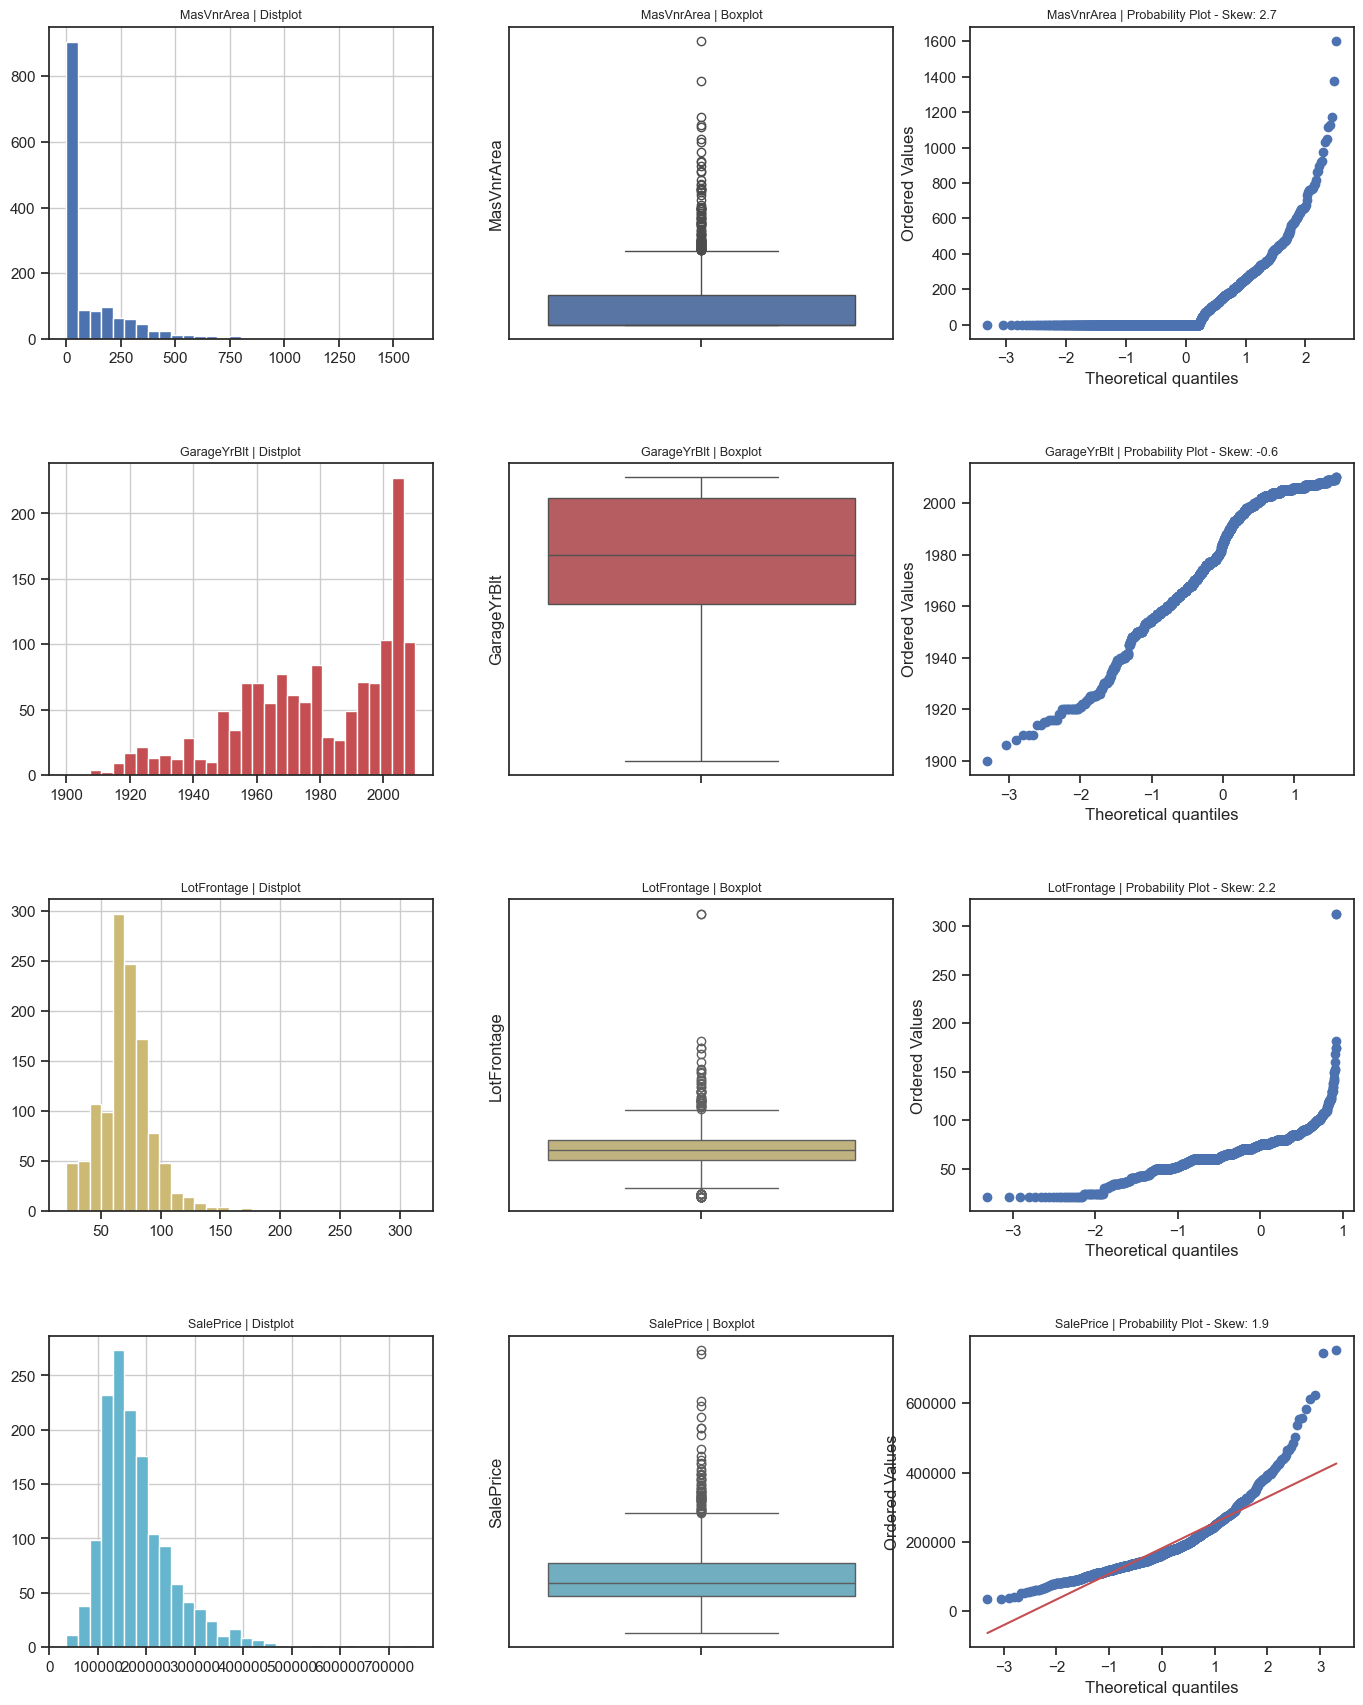

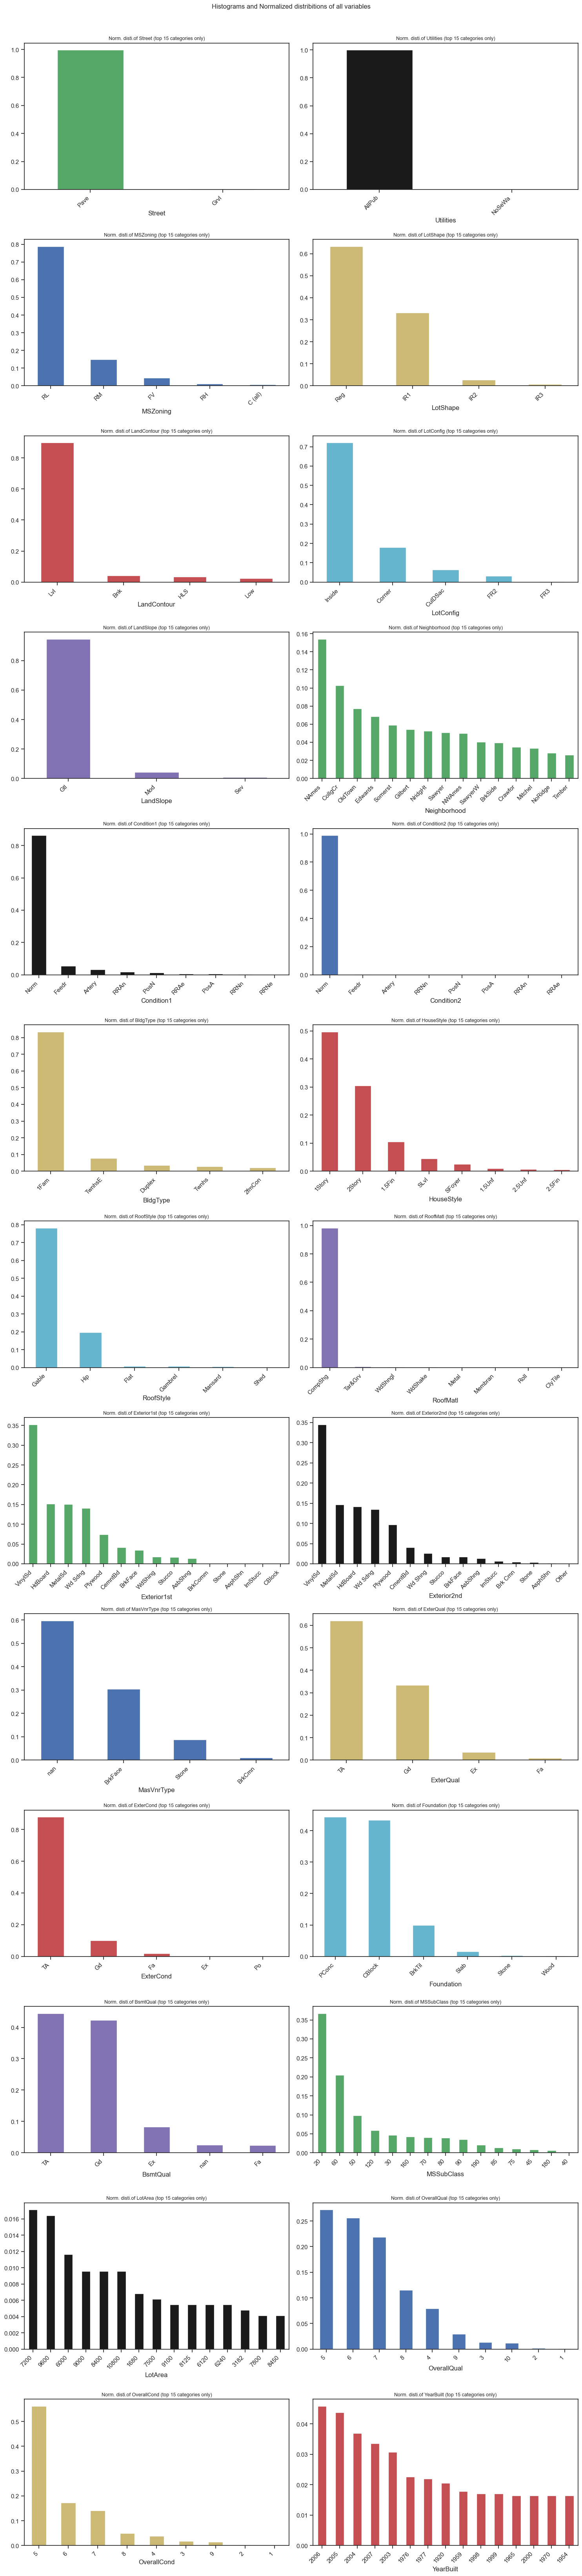

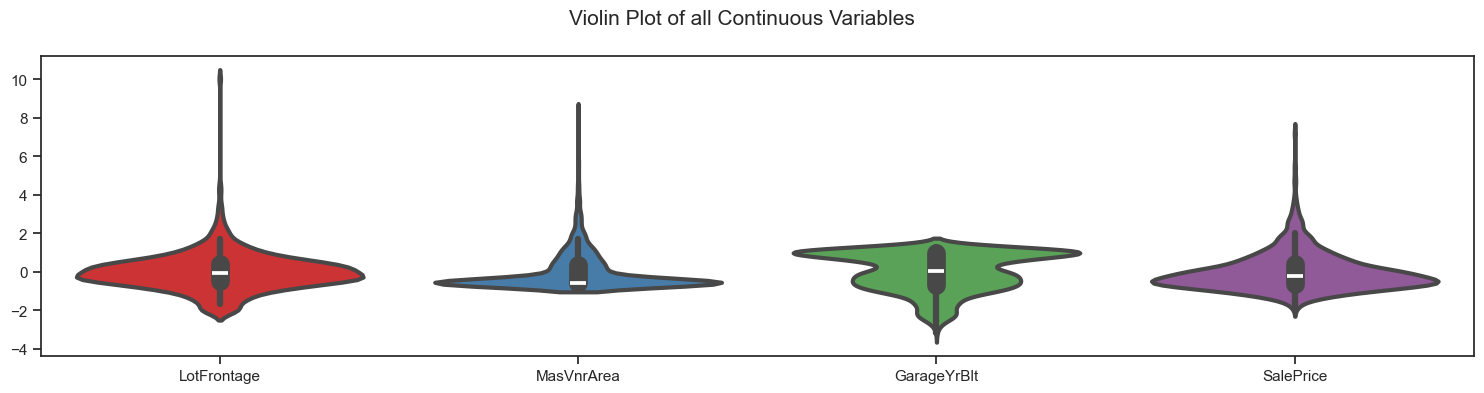

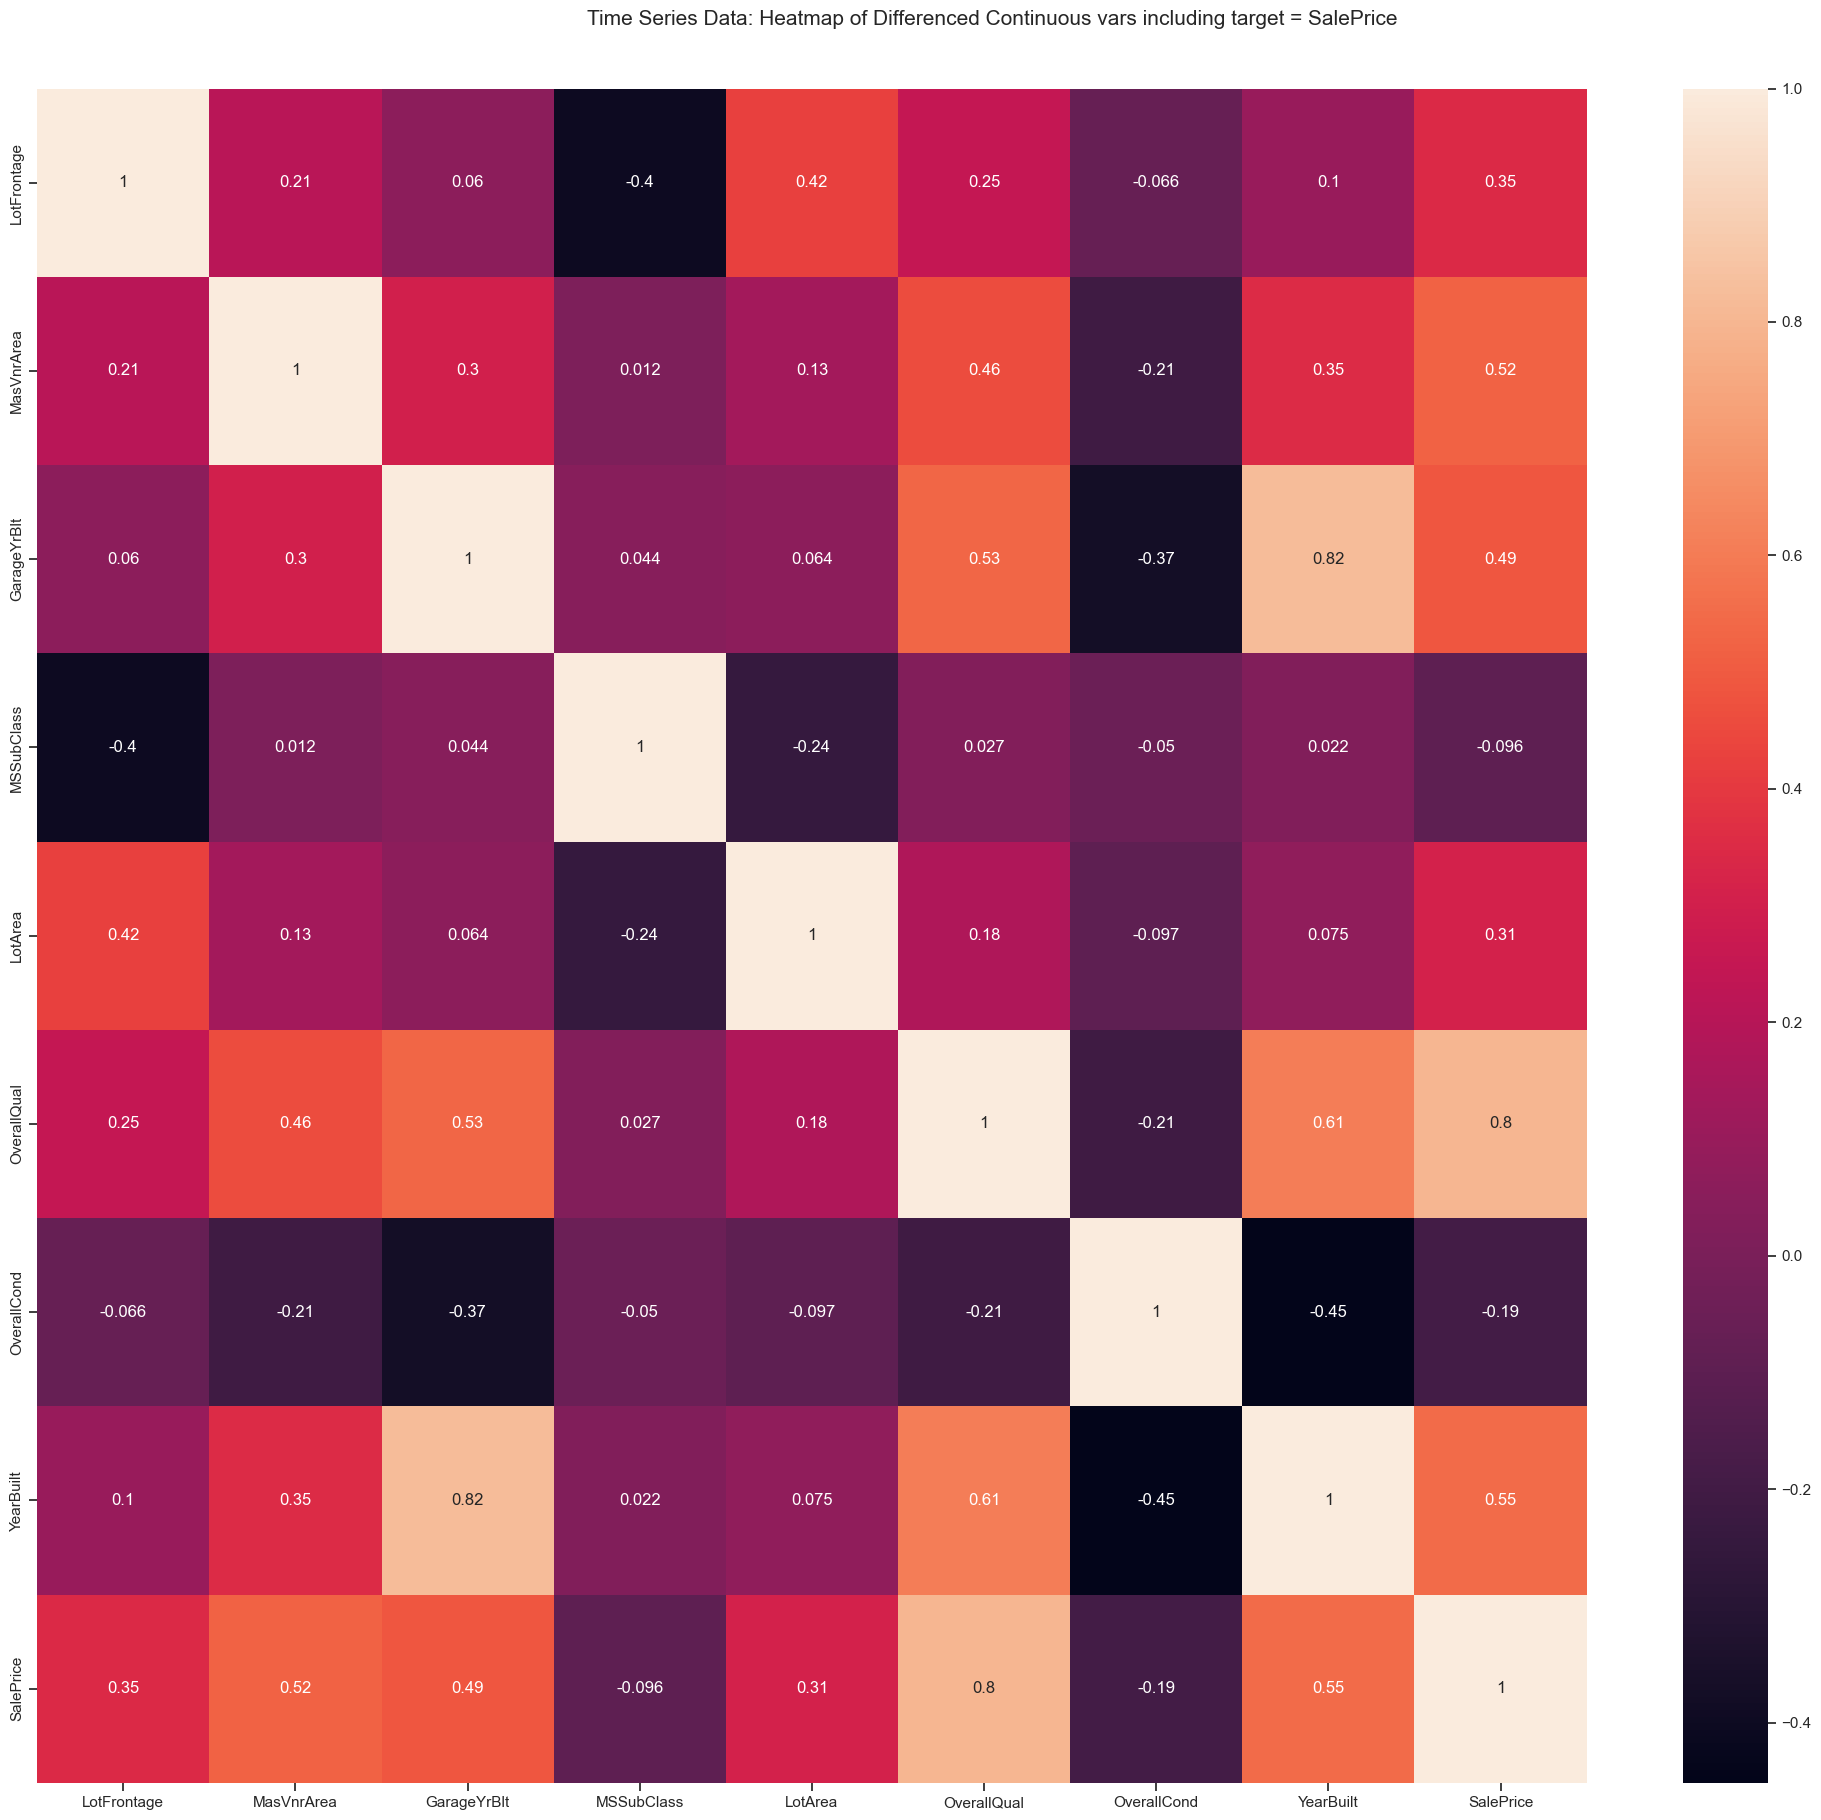

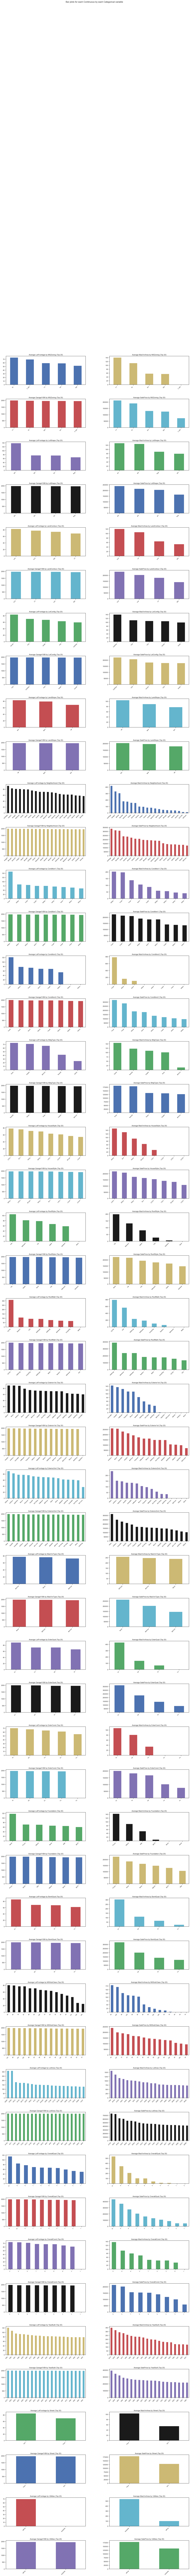

In [15]:
# ============================================
# BLOQUE 3 - Exploración automática (EDA)
# ============================================

# ydata_profiling
try:
    from ydata_profiling import ProfileReport
    prof = ProfileReport(df_train_raw, title="House Prices — Auto EDA", explorative=True)
    prof.to_file("house_prices_profile.html")
    print("✅ ydata_profiling → house_prices_profile.html")
except Exception as e:
    print("ℹ️ ydata_profiling no disponible:", e)

# Sweetviz
try:
    import sweetviz as sv
    rep = sv.analyze(df_train_raw, target_feat="SalePrice")
    rep.show_html("sweetviz_report.html")
    print("✅ Sweetviz → sweetviz_report.html")
except Exception as e:
    print("ℹ️ Sweetviz no disponible:", e)

# AutoViz
try:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    _ = AV.AutoViz(str(train_path), sep=",", depVar="SalePrice")
    print("✅ AutoViz ejecutado (gráficos inline)")
except Exception as e:
    print("ℹ️ AutoViz no disponible:", e)



## 4) AUTO FEATURE ENGINEERING

In [5]:
df_train_raw.shape

(1460, 81)

In [6]:
# ============================================
# BLOQUE 4 - Auto Feature Engineering
# ============================================

import featuretools as ft

# Unimos train + test para construir las mismas columnas
df_test_tmp = df_test_raw.copy()
df_test_tmp["SalePrice"] = np.nan
all_df = pd.concat([df_train_raw, df_test_tmp], ignore_index=True, sort=False)

# Elegimos índice único para FeatureTools
if "Id" in all_df.columns and all_df["Id"].is_unique and all_df["Id"].notna().all():
    index_col = "Id"
else:
    all_df = all_df.reset_index(drop=False).rename(columns={"index": "row_id"})
    index_col = "row_id"

# Trabajamos con numéricas para evitar explosión de combinaciones
afe_base = all_df.drop(columns=['SalePrice']).select_dtypes(include=[np.number]).copy()

# Limpieza
afe_base = afe_base.replace([np.inf, -np.inf], np.nan)
for c in afe_base.columns:
    if afe_base[c].isna().any():
        afe_base[c] = afe_base[c].fillna(afe_base[c].median())

es = ft.EntitySet(id="houses")
es = es.add_dataframe(
    dataframe_name="properties",
    dataframe=afe_base,
    index=index_col,
    make_index=False
)

trans_primitives = [
    "divide_numeric","multiply_numeric","subtract_numeric","add_numeric",
    "absolute","percentile","cum_sum","cum_mean"
]

# Limitar universo para no generar miles de columnas
num_cols_all   = [c for c in afe_base.columns if c != index_col] 
numeric_subset = sorted(num_cols_all)[:25]
ignore_cols    = [c for c in num_cols_all if c not in numeric_subset]

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="properties",
    trans_primitives=trans_primitives,
    max_depth=1,
    ignore_columns={"properties": ignore_cols},
    features_only=False
)

df_enh_all = feature_matrix.reset_index(drop=False)

# Limpieza final
num_cols_enh = df_enh_all.select_dtypes(include=[np.number]).columns
df_enh_all[num_cols_enh] = df_enh_all[num_cols_enh].replace([np.inf, -np.inf], np.nan)
for c in num_cols_enh:
    if df_enh_all[c].isna().any():
        df_enh_all[c] = df_enh_all[c].fillna(df_enh_all[c].median())

# 5) Separar nuevamente en train/test con MISMAS columnas
n_train = df_train_raw.shape[0]
df_enh_train = df_enh_all.iloc[:n_train].copy()
df_enh_test  = df_enh_all.iloc[n_train:].copy()

print("✅ AFE listo → df_enh_train:", df_enh_train.shape, "df_enh_test:", df_enh_test.shape)



✅ AFE listo → df_enh_train: (1460, 1626) df_enh_test: (1459, 1626)


## 5) LIMPIEZA Y PREPROCESAMIENTO FINAL

In [7]:
# ============================================
# BLOQUE 5 - Limpieza final
# ============================================
df_prep = df_enh_train.copy()

# Target original y en log
df_prep["SalePrice"]     = df_train_raw["SalePrice"].values
df_prep["SalePrice_log"] = np.log1p(df_prep["SalePrice"].astype(float))

# Chequeo de finitud
num_cols = df_prep.select_dtypes(include=[np.number]).columns
df_prep[num_cols] = df_prep[num_cols].replace([np.inf, -np.inf], np.nan)
for c in num_cols:
    if df_prep[c].isna().any():
        df_prep[c] = df_prep[c].fillna(df_prep[c].median())

print("✅ df_prep:", df_prep.shape)
display(df_prep.head(3))



✅ df_prep: (1460, 1628)


,Id,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,GarageArea,EnclosedPorch,3SsnPorch,MiscVal,MoSold,ABSOLUTE(1stFlrSF),ABSOLUTE(2ndFlrSF),ABSOLUTE(3SsnPorch),ABSOLUTE(BedroomAbvGr),ABSOLUTE(BsmtFinSF1),ABSOLUTE(BsmtFinSF2),ABSOLUTE(BsmtFullBath),ABSOLUTE(BsmtHalfBath),ABSOLUTE(BsmtUnfSF),ABSOLUTE(EnclosedPorch),ABSOLUTE(Fireplaces),ABSOLUTE(FullBath),ABSOLUTE(GarageArea),ABSOLUTE(GarageCars),ABSOLUTE(GarageYrBlt),ABSOLUTE(GrLivArea),ABSOLUTE(HalfBath),ABSOLUTE(KitchenAbvGr),ABSOLUTE(LotArea),ABSOLUTE(LotFrontage),ABSOLUTE(LowQualFinSF),ABSOLUTE(MSSubClass),ABSOLUTE(MasVnrArea),ABSOLUTE(MiscVal),ABSOLUTE(MoSold),1stFlrSF + 2ndFlrSF,1stFlrSF + 3SsnPorch,1stFlrSF + BedroomAbvGr,1stFlrSF + BsmtFinSF1,1stFlrSF + BsmtFinSF2,1stFlrSF + BsmtFullBath,1stFlrSF + BsmtHalfBath,1stFlrSF + BsmtUnfSF,1stFlrSF + EnclosedPorch,1stFlrSF + Fireplaces,1stFlrSF + FullBath,1stFlrSF + GarageArea,1stFlrSF + GarageCars,1stFlrSF + GarageYrBlt,1stFlrSF + GrLivArea,1stFlrSF + HalfBath,1stFlrSF + KitchenAbvGr,1stFlrSF + LotArea,1stFlrSF + LotFrontage,1stFlrSF + LowQualFinSF,1stFlrSF + MSSubClass,1stFlrSF + MasVnrArea,1stFlrSF + MiscVal,1stFlrSF + MoSold,2ndFlrSF + 3SsnPorch,2ndFlrSF + BedroomAbvGr,2ndFlrSF + BsmtFinSF1,2ndFlrSF + BsmtFinSF2,2ndFlrSF + BsmtFullBath,2ndFlrSF + BsmtHalfBath,2ndFlrSF + BsmtUnfSF,2ndFlrSF + EnclosedPorch,2ndFlrSF + Fireplaces,2ndFlrSF + FullBath,2ndFlrSF + GarageArea,2ndFlrSF + GarageCars,2ndFlrSF + GarageYrBlt,2ndFlrSF + GrLivArea,2ndFlrSF + HalfBath,2ndFlrSF + KitchenAbvGr,2ndFlrSF + LotArea,2ndFlrSF + LotFrontage,2ndFlrSF + LowQualFinSF,2ndFlrSF + MSSubClass,2ndFlrSF + MasVnrArea,2ndFlrSF + MiscVal,2ndFlrSF + MoSold,3SsnPorch + BedroomAbvGr,3SsnPorch + BsmtFinSF1,3SsnPorch + BsmtFinSF2,3SsnPorch + BsmtFullBath,3SsnPorch + BsmtHalfBath,3SsnPorch + BsmtUnfSF,3SsnPorch + EnclosedPorch,3SsnPorch + Fireplaces,3SsnPorch + FullBath,3SsnPorch + GarageArea,3SsnPorch + GarageCars,3SsnPorch + GarageYrBlt,3SsnPorch + GrLivArea,3SsnPorch + HalfBath,3SsnPorch + KitchenAbvGr,3SsnPorch + LotArea,3SsnPorch + LotFrontage,3SsnPorch + LowQualFinSF,3SsnPorch + MSSubClass,3SsnPorch + MasVnrArea,3SsnPorch + MiscVal,3SsnPorch + MoSold,BedroomAbvGr + BsmtFinSF1,BedroomAbvGr + BsmtFinSF2,BedroomAbvGr + BsmtFullBath,BedroomAbvGr + BsmtHalfBath,BedroomAbvGr + BsmtUnfSF,BedroomAbvGr + EnclosedPorch,BedroomAbvGr + Fireplaces,BedroomAbvGr + FullBath,BedroomAbvGr + GarageArea,BedroomAbvGr + GarageCars,BedroomAbvGr + GarageYrBlt,BedroomAbvGr + GrLivArea,BedroomAbvGr + HalfBath,BedroomAbvGr + KitchenAbvGr,BedroomAbvGr + LotArea,BedroomAbvGr + LotFrontage,BedroomAbvGr + LowQualFinSF,BedroomAbvGr + MSSubClass,BedroomAbvGr + MasVnrArea,BedroomAbvGr + MiscVal,BedroomAbvGr + MoSold,BsmtFinSF1 + BsmtFinSF2,BsmtFinSF1 + BsmtFullBath,BsmtFinSF1 + BsmtHalfBath,BsmtFinSF1 + BsmtUnfSF,BsmtFinSF1 + EnclosedPorch,BsmtFinSF1 + Fireplaces,BsmtFinSF1 + FullBath,BsmtFinSF1 + GarageArea,BsmtFinSF1 + GarageCars,BsmtFinSF1 + GarageYrBlt,BsmtFinSF1 + GrLivArea,BsmtFinSF1 + HalfBath,BsmtFinSF1 + KitchenAbvGr,BsmtFinSF1 + LotArea,BsmtFinSF1 + LotFrontage,BsmtFinSF1 + LowQualFinSF,BsmtFinSF1 + MSSubClass,BsmtFinSF1 + MasVnrArea,BsmtFinSF1 + MiscVal,BsmtFinSF1 + MoSold,BsmtFinSF2 + BsmtFullBath,BsmtFinSF2 + BsmtHalfBath,BsmtFinSF2 + BsmtUnfSF,BsmtFinSF2 + EnclosedPorch,BsmtFinSF2 + Fireplaces,BsmtFinSF2 + FullBath,BsmtFinSF2 + GarageArea,BsmtFinSF2 + GarageCars,BsmtFinSF2 + GarageYrBlt,BsmtFinSF2 + GrLivArea,BsmtFinSF2 + HalfBath,BsmtFinSF2 + KitchenAbvGr,BsmtFinSF2 + LotArea,BsmtFinSF2 + LotFrontage,BsmtFinSF2 + LowQualFinSF,BsmtFinSF2 + MSSubClass,BsmtFinSF2 + MasVnrArea,BsmtFinSF2 + MiscVal,BsmtFinSF2 + MoSold,BsmtFullBath + BsmtHalfBath,BsmtFullBath + BsmtUnfSF,BsmtFullBath + EnclosedPorch,BsmtFullBath + Fireplaces,BsmtFullBath + FullBath,BsmtFullBath + GarageArea,BsmtFullBath + GarageCars,BsmtFullBath + Gar

In [8]:
if "SalePrice" in df_prep.columns and "SalePrice_log" in df_prep.columns:
    df_prep = df_prep.drop(columns=["SalePrice"])
    print("✅ SalePrice eliminado (target duplicado).")



✅ SalePrice eliminado (target duplicado).


## 6) ENTRENAMIENTO AUTOML

In [9]:
# ============================================
# BLOQUE 6 - AutoML con PyCaret
# ============================================
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, pull, get_config
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

exp = setup(
    data=df_prep,
    target="SalePrice_log",
    train_size=0.8,
    fold=5,
    session_id=42,
    normalize=True,
    transformation=False,             
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    verbose=False
)

best = compare_models(sort="RMSE")
results_pc = pull(); display(results_pc.head(10))


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.1116,0.0269,0.1631,0.8235,0.0126,0.0093,13.6020
et,Extra Trees Regressor,0.1138,0.0277,0.1660,0.8170,0.0128,0.0095,14.4520
lightgbm,Light Gradient Boosting Machine,0.1147,0.0279,0.1663,0.8161,0.0129,0.0096,9.9920
rf,Random Forest Regressor,0.1170,0.0290,0.1696,0.8087,0.0131,0.0098,21.7980
xgboost,Extreme Gradient Boosting,0.1227,0.0306,0.1743,0.7987,0.0135,0.0103,11.9100
ada,AdaBoost Regressor,0.1393,0.0351,0.1866,0.7697,0.0144,0.0116,8.6640
omp,Orthogonal Matching Pursuit,0.1310,0.0391,0.1964,0.7429,0.0152,0.0109,5.8220
knn,K Neighbors Regressor,0.1421,0.0409,0.2013,0.7303,0.0155,0.0118,5.7260
br,Bayesian Ridge,0.1213,0.0568,0.2160,0.6197,0.0181,0.0101,6.1460
dt,Decision Tree Regressor,0.1721,0.0586,0.2417,0.6117,0.0186,0.0144,5.9600


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.1116,0.0269,0.1631,0.8235,0.0126,0.0093,13.602
et,Extra Trees Regressor,0.1138,0.0277,0.1660,0.8170,0.0128,0.0095,14.452
lightgbm,Light Gradient Boosting Machine,0.1147,0.0279,0.1663,0.8161,0.0129,0.0096,9.992
rf,Random Forest Regressor,0.1170,0.0290,0.1696,0.8087,0.0131,0.0098,21.798
xgboost,Extreme Gradient Boosting,0.1227,0.0306,0.1743,0.7987,0.0135,0.0103,11.910
ada,AdaBoost Regressor,0.1393,0.0351,0.1866,0.7697,0.0144,0.0116,8.664
omp,Orthogonal Matching Pursuit,0.1310,0.0391,0.1964,0.7429,0.0152,0.0109,5.822
knn,K Neighbors Regressor,0.1421,0.0409,0.2013,0.7303,0.0155,0.0118,5.726
br,Bayesian Ridge,0.1213,0.0568,0.2160,0.6197,0.0181,0.0101,6.146
dt,Decision Tree Regressor,0.1721,0.0586,0.2417,0.6117,0.0186,0.0144,5.960


In [10]:
try:
    tuned = tune_model(best, optimize="RMSE")
except Exception as e:
    print(f"⚠️ tune_model falló con {best.__class__.__name__}: {e}. Uso el base.")
    tuned = best

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0991,0.0232,0.1523,0.8457,0.0117,0.0083
1,0.1162,0.0311,0.1765,0.7859,0.0135,0.0097
2,0.1223,0.0331,0.1818,0.8244,0.0141,0.0103
3,0.1071,0.0227,0.1507,0.8445,0.0117,0.0090
4,0.1002,0.0214,0.1462,0.8332,0.0114,0.0084
Mean,0.1090,0.0263,0.1615,0.8268,0.0125,0.0091
Std,0.0090,0.0048,0.0146,0.0218,0.0011,0.0008


Fitting 5 folds for each of 10 candidates, totalling 50 fits


## 7) EVALUACION DEL MODELO

In [14]:
# ============================================
# BLOQUE 7 - Evaluación del modelo
# ============================================

from pycaret.regression import get_config, predict_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# 1) Columnas con las que el modelo fue entrenado
fit_cols = get_config("X_train").columns

# 2) Holdout interno de PyCaret
X_hold  = get_config("X_test").copy()
y_hold  = get_config("y_test").copy()    

# 3) Alinear explícitamente columnas
X_hold_aligned = X_hold.reindex(columns=fit_cols, fill_value=0)

# Diagnóstico de columnas
missing_in_hold = [c for c in fit_cols if c not in X_hold.columns]
extra_in_hold   = [c for c in X_hold.columns if c not in fit_cols]
print(f"ℹ️ Cols faltantes en holdout: {len(missing_in_hold)} | Cols extra en holdout: {len(extra_in_hold)}")

# 4) Predicción con el modelo final
# y_pred_log = final_model.predict(X_hold_aligned)

preds = predict_model(tuned, data=X_hold_aligned)

# 5) Volver a escala original
y_true = np.expm1(y_hold)
# y_pred = np.expm1(y_pred_log)
y_pred = np.expm1(preds["prediction_label"].values)

# 6) Métricas
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2   = r2_score(y_true, y_pred)

print(f"📏 Holdout (alineado) | MAE={mae:,.0f} | MAPE={mape:,.2%}| RMSE={rmse:,.0f} | R²={r2:.3f}")

# 7) Muestra
pred_show = pd.DataFrame({"SalePrice_true": y_true, "SalePrice_pred": y_pred}).head(10)
display(pred_show)



ℹ️ Cols faltantes en holdout: 0 | Cols extra en holdout: 0


📏 Holdout (alineado) | MAE=19,731 | MAPE=12.07%| RMSE=32,784 | R²=0.860


,SalePrice_true,SalePrice_pred
892,154500.031250,133920.467813
1105,325000.031250,308045.051789
413,114999.945312,123765.037440
522,158999.953125,164250.202946
1036,315499.875000,278465.831698
614,75500.000000,70467.030108
218,311499.906250,205079.142534
1160,146000.015625,146824.281253
649,84500.000000,66700.844889
887,135500.000000,127226.120386


Finalizamos el modelo:

In [ ]:
final_model = finalize_model(tuned)
print("✅ Modelo final (PyCaret):", final_model)

## INTERPRETABILIDAD

In [ ]:
# ============================================
# BLOQUE 8 — Interpretabilidad
# ============================================
from pycaret.regression import plot_model, get_config
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- 0) Recupero el holdout alineado del BLOQUE 7
fit_cols = get_config("X_train").columns
X_hold  = get_config("X_test").copy()
y_hold  = get_config("y_test").copy()           # en log
X_hold_aligned = X_hold.reindex(columns=fit_cols, fill_value=0)

y_pred_log = final_model.predict(X_hold_aligned)
y_true = np.expm1(y_hold)
y_pred = np.expm1(y_pred_log)

# --- 1) Intento gráficos nativos de PyCaret ---
ok_feature, ok_error = True, True
try:
    plot_model(final_model, plot="feature")
except Exception as e:
    ok_feature = False
    print(f"ℹ️ plot_model(feature) falló, uso fallback (Permutation Importance). Motivo: {e}")

try:
    plot_model(final_model, plot="error")
except Exception as e:
    ok_error = False
    print(f"ℹ️ plot_model(error) falló, uso fallback (residuales manual). Motivo: {e}")

# --- 2) Fallback: Permutation Importance (top 20) ---
if not ok_feature:
    try:
        # Para evitar tiempos largos, uso una muestra si el holdout es grande
        print("Utilizando permutation importance")
        rng = np.random.default_rng(42)
        n = min(100, X_hold_aligned.shape[0])
        idx = rng.choice(X_hold_aligned.index, size=n, replace=False)
        X_pi = X_hold_aligned.loc[idx]
        y_pi = y_hold.loc[idx]

        pi = permutation_importance(
            final_model, X_pi, y_pi, scoring="neg_root_mean_squared_error",
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp_df = pd.DataFrame({
            "feature": X_pi.columns,
            "importance": pi.importances_mean,
            "std": pi.importances_std
        }).sort_values("importance", ascending=False).head(20)
        display(imp_df.reset_index(drop=True))
        try:
            import matplotlib.pyplot as plt
            print("Plotteando...")
            plt.figure(figsize=(8,6))
            plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
            plt.title("Permutation Importance (top 20)")
            plt.tight_layout()
            plt.show()
        except Exception:
            pass
    except Exception as e:
        print("⚠️ Fallback de importancias también falló:", e)

# --- 3) Fallback: residuales/errores manual ---
if not ok_error:
    try:
        resid = y_true - y_pred
        err_df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "residual": resid})
        display(err_df.head())

        try:
            import matplotlib.pyplot as plt
            # Pred vs Real
            plt.figure(figsize=(6,5))
            plt.scatter(y_true, y_pred, alpha=0.5)
            lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
            plt.plot(lims, lims)
            plt.xlabel("Real")
            plt.ylabel("Predicción")
            plt.title("Predicción vs Real (holdout)")
            plt.tight_layout()
            plt.show()

            # Residuales
            plt.figure(figsize=(6,5))
            plt.scatter(y_pred, resid, alpha=0.5)
            plt.axhline(0, lw=1)
            plt.xlabel("Predicción")
            plt.ylabel("Residual")
            plt.title("Residuales (holdout)")
            plt.tight_layout()
            plt.show()
        except Exception:
            pass

        mae  = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2   = r2_score(y_true, y_pred)
        print(f"📏 Métricas (holdout) | MAE={mae:,.0f} | RMSE={rmse:,.0f} | R²={r2:.3f}")
    except Exception as e:
        print("⚠️ Fallback de residuales también falló:", e)

print("✅ Interpretabilidad: bloque completado con caminos alternativos si hizo falta.")


ℹ️ plot_model(feature) falló, uso fallback (Permutation Importance). Motivo: All arrays must be of the same length


ℹ️ plot_model(error) falló, uso fallback (residuales manual). Motivo: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 1stFlrSF / 3SsnPorch
- 1stFlrSF / MiscVal
- 3SsnPorch * EnclosedPorch
- 3SsnPorch * LowQualFinSF
- 3SsnPorch / EnclosedPorch
- ...
Feature names seen at fit time, yet now missing:
- 1stFlrSF * MasVnrArea
- 1stFlrSF / 2ndFlrSF
- 3SsnPorch * MiscVal
- 3SsnPorch - BsmtUnfSF
- 3SsnPorch / BsmtHalfBath
- ...

Utilizando permutation importance


## 9) Validacion cruzada

In [ ]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Columnas finales del pipeline 
fit_cols = get_config("X_train").columns

# Armado del train alineado
X_all_aligned = df_prep.drop(columns=["SalePrice_log"]).reindex(columns=fit_cols, fill_value=0)
y_all = df_prep["SalePrice_log"]

cv = KFold(n_splits=5, shuffle=True, random_state=42)
maes, rmses, r2s = [], [], []

for tr_idx, va_idx in cv.split(X_all_aligned):
    X_tr, X_va = X_all_aligned.iloc[tr_idx], X_all_aligned.iloc[va_idx]
    y_tr, y_va = y_all.iloc[tr_idx], y_all.iloc[va_idx]

    m = clone(final_model)
    m.fit(X_tr, y_tr)

    y_va_pred_log = m.predict(X_va)
    y_va_true = np.expm1(y_va)
    y_va_pred = np.expm1(y_va_pred_log)

    maes.append(mean_absolute_error(y_va_true, y_va_pred))
    rmses.append(mean_squared_error(y_va_true, y_va_pred, squared=False))
    r2s.append(r2_score(y_va_true, y_va_pred))

print(f"🔁 CV(5) (escala real) | MAE: {np.mean(maes):,.0f} ± {np.std(maes):,.0f} | "
      f"RMSE: {np.mean(rmses):,.0f} ± {np.std(rmses):,.0f} | R²: {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")



In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

X_hold  = get_config("X_test").copy()
y_hold  = get_config("y_test").copy()
X_hold_aligned = X_hold.reindex(columns=fit_cols, fill_value=0)

y_pred_log = final_model.predict(X_hold_aligned)
y_true = np.expm1(y_hold)
y_pred = np.expm1(y_pred_log)

mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2   = r2_score(y_true, y_pred)

print(f"📏 Holdout | MAE={mae:,.0f} | RMSE={rmse:,.0f} | R²={r2:.3f}")

pred_show = pd.DataFrame({"SalePrice_true": y_true, "SalePrice_pred": y_pred})
display(pred_show.head(10))


📏 Holdout | MAE=12,534 | RMSE=17,936 | R²=0.958


,SalePrice_true,SalePrice_pred
892,154500.031250,138667.915077
1105,325000.031250,331342.677146
413,114999.945312,110260.173490
522,158999.953125,161751.440602
1036,315499.875000,313398.923945
614,75500.000000,80836.882318
218,311499.906250,232514.312883
1160,146000.015625,144295.408288
649,84500.000000,81053.542421
887,135500.000000,125941.574362


## 10) GUARDAR MODELO

In [11]:
# === 1) Guardar modelo + columnas + metadatos ===
from pycaret.regression import save_model, get_config
import pandas as pd, json, joblib, sys, platform, datetime as dt

MODEL_ARTIFACTS_DIR = "model_artifacts"
MODEL_NAME = "houseprice_final_model"
 
# Guardamos el modelo
save_model(final_model, f"{MODEL_ARTIFACTS_DIR}/{MODEL_NAME}")

# Guardamos caracteristicas
joblib.dump(feature_defs, f"{MODEL_ARTIFACTS_DIR}/feature_defs.pkl")

fit_cols = get_config("X_train").columns
pd.Series(fit_cols).to_csv(f"{MODEL_ARTIFACTS_DIR}/model_columns.csv", index=False)

# metadatos
card = {
    "model_name": MODEL_NAME,
    "created_at": dt.datetime.now().isoformat(timespec="seconds"),
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "notes": "Target en log; devolver a escala con expm1; reindex con model_columns.csv"
}
with open(f"{MODEL_ARTIFACTS_DIR}/model_card.json", "w") as f:
    json.dump(card, f, indent=2)

print("✅ Artefactos guardados: ", MODEL_NAME + ".pkl", "model_columns.csv", "model_card.json", "feature_defs.pkl", sep="\n- ")

Transformation Pipeline and Model Successfully Saved
✅ Artefactos guardados: 
- houseprice_final_model.pkl
- model_columns.csv
- model_card.json
- feature_defs.pkl
